In [14]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = torch.load("../64torchiodataset.pt")


lengths = [
    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]

# trainset, valset, testset = random_split(dataset, lengths)
# image_datasets = {'train': trainset, 'val': valset, 'test': testset}
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
#               for x in ['train', 'val', 'test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  


NC = []
AD = []
for data in dataset:
    if data[1] == 0:
        NC.append(data)
    else:
        AD.append(data)
        
NC = [sample[0] for sample in NC]
NCgan1 = [torch.unsqueeze(sample[0][0], 0) for sample in NC]
NCgan2 = [torch.unsqueeze(sample[1][0], 0) for sample in NC]
NCgan3 = [torch.unsqueeze(sample[2][0], 0) for sample in NC]

AD = [sample[0] for sample in AD]
ADgan1 = [torch.unsqueeze(sample[0][0], 0) for sample in AD]
ADgan2 = [torch.unsqueeze(sample[1][0], 0) for sample in AD]
ADgan3 = [torch.unsqueeze(sample[2][0], 0) for sample in AD]

gan1 = []
for i in range(len(ADgan1)):
    gan1.append({"A": NCgan1[i], "B": ADgan1[i]})

gan2 = []
for i in range(len(ADgan2)):
    gan2.append({"A": NCgan2[i], "B": ADgan2[i]})
    
gan3 = []
for i in range(len(ADgan3)):
    gan3.append({"A": NCgan3[i], "B": ADgan3[i]})
    
batch_size = 1
dataloader1 = DataLoader(gan1, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader2 = DataLoader(gan2, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader3 = DataLoader(gan3, batch_size=batch_size, shuffle=True, num_workers=4)


In [3]:
import random
import time
import datetime
import sys

from torch.autograd import Variable
import torch
import numpy as np

from torchvision.utils import save_image


class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(3), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [22]:
import os
import numpy as np
import math
import itertools
import datetime
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable


import torch.nn as nn
import torch.nn.functional as F
import torch


epoch = 0
n_epochs = 200
dataset_name = 'CycleGAN'
batch_size = 1
lr=0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
n_cpu = 8
img_height = 64
img_width = 64
channels = 1
sample_interval = 100
checkpoint_interval = 100
n_residual_blocks = 9
lambda_cyc = 10
lambda_id = 5

# Create sample and checkpoint directories
os.makedirs("images/%s" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)




def sample_images(batches_done, images):
    """Saves a generated sample from the test set"""
    imgs = next(iter(dataloader3))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)

    real_A = make_grid(real_A, nrow=4, normalize=True)
    real_B = make_grid(real_B, nrow=4, normalize=True)
    fake_A = make_grid(fake_A, nrow=4, normalize=True)
    fake_B = make_grid(fake_B, nrow=4, normalize=True)

    image_grid = torch.stack((real_A, fake_B, real_B, fake_A), 0)
    save_image(image_grid, "images/%s/%s.png" % (dataset_name, batches_done), normalize=False)
    images.append(fake_B)


In [24]:
# Losses
criterion_GAN = torch.nn.MSELoss().cuda()
criterion_cycle = torch.nn.L1Loss().cuda()
criterion_identity = torch.nn.L1Loss().cuda()

input_shape = (channels, img_height, img_width)

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, n_residual_blocks).cuda()
G_BA = GeneratorResNet(input_shape, n_residual_blocks).cuda()
D_A = Discriminator(input_shape).cuda()
D_B = Discriminator(input_shape).cuda()


# if epoch != 0:
#     # Load pretrained models
#     G_AB.load_state_dict(torch.load("saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch)))
#     G_BA.load_state_dict(torch.load("saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch)))
#     D_A.load_state_dict(torch.load("saved_models/%s/D_A_%d.pth" % (dataset_name, epoch)))
#     D_B.load_state_dict(torch.load("saved_models/%s/D_B_%d.pth" % (dataset_name, epoch)))
# else:
    # Initialize weights
    
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

epoch = 0
img_grids = []
images = []
G_losses = []
D_losses = []

def train_gan(dataloader, epoch):
    prev_time = time.time()
    for epoch in range(epoch, n_epochs):
        for i, batch in enumerate(dataloader):

            # Set model input
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))

            # Adversarial ground truths
            valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
            fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

            # ------------------
            #  Train Generators
            # ------------------

            G_AB.train()
            G_BA.train()

            optimizer_G.zero_grad()


            # Identity loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)

            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN loss
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle loss
            recov_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total loss
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

            loss_G.backward()
            optimizer_G.step()

            # -----------------------
            #  Train Discriminator A
            # -----------------------
            
#             if i%5 == 0:
            optimizer_D_A.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_A(real_A), valid)
            # Fake loss (on batch of previously generated samples)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
            # Total loss
            loss_D_A = (loss_real + loss_fake) / 2

            loss_D_A.backward()
            optimizer_D_A.step()

            # -----------------------
            #  Train Discriminator B
            # -----------------------

            optimizer_D_B.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_B(real_B), valid)
            # Fake loss (on batch of previously generated samples)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2

            loss_D_B.backward()
            optimizer_D_B.step()

            loss_D = (loss_D_A + loss_D_B) / 2

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(dataloader) + i
            batches_left = n_epochs * len(dataloader) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            # Print log
            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )

            # If at sample interval save image
            if batches_done % sample_interval == 0:
                sample_images(batches_done, images)
                
            
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())
            
            
        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

        if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
            # Save model checkpoints
            torch.save(G_AB.state_dict(), "saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch))
            torch.save(G_BA.state_dict(), "saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch))
            torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (dataset_name, epoch))
            torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (dataset_name, epoch))
            
            
train_gan(dataloader3, epoch)

[Epoch 0/200] [Batch 0/476] [D loss: 1.501719] [G loss: 18.543667, adv: 1.582060, cycle: 1.134011, identity: 1.124300] ETA: 4:12:17.791061
[Epoch 0/200] [Batch 1/476] [D loss: 0.949080] [G loss: 16.386539, adv: 1.299144, cycle: 1.012905, identity: 0.991669] ETA: 7:16:09.497637
[Epoch 0/200] [Batch 2/476] [D loss: 1.178904] [G loss: 14.796091, adv: 0.874161, cycle: 0.942109, identity: 0.900167] ETA: 1:54:18.548270
[Epoch 0/200] [Batch 3/476] [D loss: 1.328289] [G loss: 15.049623, adv: 1.293544, cycle: 0.920362, identity: 0.910493] ETA: 2:08:57.180261
[Epoch 0/200] [Batch 4/476] [D loss: 1.335779] [G loss: 15.521496, adv: 1.337486, cycle: 0.959807, identity: 0.917188] ETA: 2:13:52.130725
[Epoch 0/200] [Batch 5/476] [D loss: 1.566680] [G loss: 14.951328, adv: 1.298429, cycle: 0.922444, identity: 0.885692] ETA: 2:26:08.766841
[Epoch 0/200] [Batch 6/476] [D loss: 1.333152] [G loss: 15.137934, adv: 2.075458, cycle: 0.871168, identity: 0.870160] ETA: 2:28:36.244237
[Epoch 0/200] [Batch 7/476]

[Epoch 0/200] [Batch 61/476] [D loss: 0.857085] [G loss: 12.511961, adv: 0.598195, cycle: 0.794197, identity: 0.794359] ETA: 2:08:24.430213
[Epoch 0/200] [Batch 62/476] [D loss: 0.761402] [G loss: 13.469864, adv: 0.930161, cycle: 0.839690, identity: 0.828560] ETA: 1:58:32.240899
[Epoch 0/200] [Batch 63/476] [D loss: 1.068980] [G loss: 14.176489, adv: 1.172626, cycle: 0.872244, identity: 0.856284] ETA: 1:55:17.800413
[Epoch 0/200] [Batch 64/476] [D loss: 0.409445] [G loss: 13.028399, adv: 0.610654, cycle: 0.831173, identity: 0.821203] ETA: 1:58:03.738647
[Epoch 0/200] [Batch 65/476] [D loss: 0.715007] [G loss: 13.476646, adv: 1.129915, cycle: 0.823764, identity: 0.821819] ETA: 2:11:03.764547
[Epoch 0/200] [Batch 66/476] [D loss: 0.448818] [G loss: 12.557994, adv: 0.748142, cycle: 0.793723, identity: 0.774525] ETA: 1:50:22.062231
[Epoch 0/200] [Batch 67/476] [D loss: 0.513179] [G loss: 13.069698, adv: 1.087348, cycle: 0.799966, identity: 0.796538] ETA: 2:04:43.865980
[Epoch 0/200] [Batch

[Epoch 0/200] [Batch 122/476] [D loss: 0.285113] [G loss: 11.724781, adv: 0.413489, cycle: 0.755050, identity: 0.752159] ETA: 2:00:14.432783
[Epoch 0/200] [Batch 123/476] [D loss: 0.331450] [G loss: 11.173638, adv: 0.365829, cycle: 0.724923, identity: 0.711716] ETA: 1:51:39.699834
[Epoch 0/200] [Batch 124/476] [D loss: 0.313849] [G loss: 11.526251, adv: 0.373365, cycle: 0.742756, identity: 0.745066] ETA: 2:01:54.314401
[Epoch 0/200] [Batch 125/476] [D loss: 0.333218] [G loss: 11.228354, adv: 0.405072, cycle: 0.722914, identity: 0.718828] ETA: 2:17:14.883928
[Epoch 0/200] [Batch 126/476] [D loss: 0.304243] [G loss: 11.376582, adv: 0.743700, cycle: 0.710578, identity: 0.705420] ETA: 2:19:07.182323
[Epoch 0/200] [Batch 127/476] [D loss: 0.274955] [G loss: 11.269028, adv: 0.480984, cycle: 0.718495, identity: 0.720618] ETA: 2:07:53.607584
[Epoch 0/200] [Batch 128/476] [D loss: 0.512780] [G loss: 11.047346, adv: 0.161028, cycle: 0.728195, identity: 0.720874] ETA: 2:01:36.485138
[Epoch 0/200]

[Epoch 0/200] [Batch 182/476] [D loss: 0.233949] [G loss: 11.172281, adv: 0.345657, cycle: 0.719846, identity: 0.725632] ETA: 2:20:45.001854
[Epoch 0/200] [Batch 183/476] [D loss: 0.443356] [G loss: 11.885315, adv: 0.568147, cycle: 0.750161, identity: 0.763111] ETA: 2:06:01.414069
[Epoch 0/200] [Batch 184/476] [D loss: 0.357236] [G loss: 11.144539, adv: 0.515581, cycle: 0.705473, identity: 0.714846] ETA: 1:57:50.386110
[Epoch 0/200] [Batch 185/476] [D loss: 0.244799] [G loss: 10.727571, adv: 0.558142, cycle: 0.680346, identity: 0.673193] ETA: 1:59:15.624181
[Epoch 0/200] [Batch 186/476] [D loss: 0.358517] [G loss: 12.185367, adv: 0.700716, cycle: 0.768005, identity: 0.760919] ETA: 2:07:29.363860
[Epoch 0/200] [Batch 187/476] [D loss: 0.282114] [G loss: 11.054252, adv: 0.331224, cycle: 0.716040, identity: 0.712525] ETA: 2:09:32.809422
[Epoch 0/200] [Batch 188/476] [D loss: 0.204286] [G loss: 11.233307, adv: 0.280892, cycle: 0.729119, identity: 0.732245] ETA: 2:07:39.441832
[Epoch 0/200]

[Epoch 0/200] [Batch 241/476] [D loss: 0.270605] [G loss: 11.410960, adv: 0.709704, cycle: 0.711536, identity: 0.717180] ETA: 2:06:22.336362
[Epoch 0/200] [Batch 242/476] [D loss: 0.205919] [G loss: 11.490577, adv: 0.484824, cycle: 0.736328, identity: 0.728495] ETA: 2:05:18.163377
[Epoch 0/200] [Batch 243/476] [D loss: 0.232979] [G loss: 10.868603, adv: 0.259314, cycle: 0.707691, identity: 0.706476] ETA: 2:06:42.710703
[Epoch 0/200] [Batch 244/476] [D loss: 0.146107] [G loss: 10.837130, adv: 0.196058, cycle: 0.711327, identity: 0.705561] ETA: 2:11:11.019238
[Epoch 0/200] [Batch 245/476] [D loss: 0.348247] [G loss: 11.631080, adv: 0.620103, cycle: 0.733609, identity: 0.734977] ETA: 2:04:54.698205
[Epoch 0/200] [Batch 246/476] [D loss: 0.229427] [G loss: 11.155394, adv: 0.393437, cycle: 0.715528, identity: 0.721336] ETA: 2:01:19.867640
[Epoch 0/200] [Batch 247/476] [D loss: 0.222458] [G loss: 10.808279, adv: 0.477408, cycle: 0.687900, identity: 0.690374] ETA: 2:09:35.824447
[Epoch 0/200]

[Epoch 0/200] [Batch 300/476] [D loss: 0.306987] [G loss: 11.783173, adv: 0.375321, cycle: 0.758621, identity: 0.764328] ETA: 1:53:59.522433
[Epoch 0/200] [Batch 301/476] [D loss: 0.270840] [G loss: 11.567945, adv: 0.328958, cycle: 0.746523, identity: 0.754751] ETA: 5:46:27.234725
[Epoch 0/200] [Batch 302/476] [D loss: 0.200933] [G loss: 11.242805, adv: 0.492370, cycle: 0.716413, identity: 0.717262] ETA: 2:17:09.417837
[Epoch 0/200] [Batch 303/476] [D loss: 0.170038] [G loss: 11.078963, adv: 0.414686, cycle: 0.709945, identity: 0.712965] ETA: 2:12:44.118432
[Epoch 0/200] [Batch 304/476] [D loss: 0.219407] [G loss: 11.159268, adv: 0.385382, cycle: 0.718629, identity: 0.717518] ETA: 2:11:45.865711
[Epoch 0/200] [Batch 305/476] [D loss: 0.200633] [G loss: 10.989758, adv: 0.321516, cycle: 0.707943, identity: 0.717761] ETA: 2:16:00.333250
[Epoch 0/200] [Batch 306/476] [D loss: 0.257821] [G loss: 10.726874, adv: 0.230935, cycle: 0.699604, identity: 0.699980] ETA: 2:20:53.845297
[Epoch 0/200]

[Epoch 0/200] [Batch 361/476] [D loss: 0.331057] [G loss: 11.204717, adv: 0.456752, cycle: 0.718113, identity: 0.713368] ETA: 2:03:44.514333
[Epoch 0/200] [Batch 362/476] [D loss: 0.219160] [G loss: 10.389437, adv: 0.237358, cycle: 0.677557, identity: 0.675302] ETA: 2:15:44.171284
[Epoch 0/200] [Batch 363/476] [D loss: 0.169991] [G loss: 11.861198, adv: 0.608197, cycle: 0.748245, identity: 0.754111] ETA: 2:07:00.575177
[Epoch 0/200] [Batch 364/476] [D loss: 0.278701] [G loss: 10.946809, adv: 0.388451, cycle: 0.703526, identity: 0.704620] ETA: 2:18:22.387239
[Epoch 0/200] [Batch 365/476] [D loss: 0.267770] [G loss: 10.288122, adv: 0.355123, cycle: 0.662594, identity: 0.661412] ETA: 2:07:54.747322
[Epoch 0/200] [Batch 366/476] [D loss: 0.221913] [G loss: 10.328324, adv: 0.523860, cycle: 0.658070, identity: 0.644752] ETA: 2:06:30.963480
[Epoch 0/200] [Batch 367/476] [D loss: 0.186654] [G loss: 11.298906, adv: 0.487218, cycle: 0.720537, identity: 0.721264] ETA: 2:08:30.535286
[Epoch 0/200]

[Epoch 0/200] [Batch 420/476] [D loss: 0.228149] [G loss: 11.233893, adv: 0.263228, cycle: 0.731879, identity: 0.730376] ETA: 2:20:20.843468
[Epoch 0/200] [Batch 421/476] [D loss: 0.269226] [G loss: 10.528720, adv: 0.230592, cycle: 0.687452, identity: 0.684722] ETA: 2:17:37.897506
[Epoch 0/200] [Batch 422/476] [D loss: 0.270106] [G loss: 11.351448, adv: 0.797872, cycle: 0.699006, identity: 0.712703] ETA: 2:11:09.506346
[Epoch 0/200] [Batch 423/476] [D loss: 0.246655] [G loss: 10.943610, adv: 0.759376, cycle: 0.676666, identity: 0.683514] ETA: 1:58:30.697355
[Epoch 0/200] [Batch 424/476] [D loss: 0.273282] [G loss: 11.106889, adv: 0.210472, cycle: 0.723624, identity: 0.732035] ETA: 1:58:49.151344
[Epoch 0/200] [Batch 425/476] [D loss: 0.152747] [G loss: 10.818686, adv: 0.521624, cycle: 0.687030, identity: 0.685353] ETA: 2:00:40.813941
[Epoch 0/200] [Batch 426/476] [D loss: 0.205483] [G loss: 10.276451, adv: 0.494473, cycle: 0.652215, identity: 0.651965] ETA: 2:08:15.976784
[Epoch 0/200]

[Epoch 1/200] [Batch 3/476] [D loss: 0.271287] [G loss: 10.942940, adv: 0.623739, cycle: 0.684465, identity: 0.694910] ETA: 2:05:56.331606
[Epoch 1/200] [Batch 4/476] [D loss: 0.207908] [G loss: 10.546795, adv: 0.220155, cycle: 0.686736, identity: 0.691855] ETA: 1:58:20.662231
[Epoch 1/200] [Batch 5/476] [D loss: 0.318623] [G loss: 12.110813, adv: 0.531215, cycle: 0.770575, identity: 0.774770] ETA: 1:46:18.909705
[Epoch 1/200] [Batch 6/476] [D loss: 0.182738] [G loss: 11.824814, adv: 0.569916, cycle: 0.746407, identity: 0.758165] ETA: 1:58:42.304444
[Epoch 1/200] [Batch 7/476] [D loss: 0.165158] [G loss: 10.313436, adv: 0.376495, cycle: 0.659626, identity: 0.668136] ETA: 2:00:41.079855
[Epoch 1/200] [Batch 8/476] [D loss: 0.132941] [G loss: 11.402140, adv: 0.512134, cycle: 0.724687, identity: 0.728627] ETA: 1:52:27.088717
[Epoch 1/200] [Batch 9/476] [D loss: 0.320939] [G loss: 11.748655, adv: 0.942275, cycle: 0.720522, identity: 0.720232] ETA: 1:55:44.359970
[Epoch 1/200] [Batch 10/476

KeyboardInterrupt: 

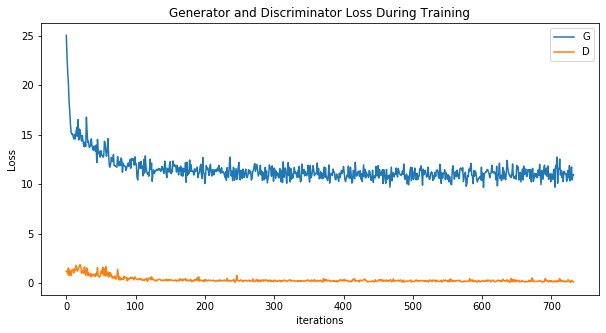

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [26]:
images[0].shape

torch.Size([3, 64, 64])